In [124]:
import pandas as pd

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [2]:
import tensorflow as tf

import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

print(tf.__version__)

1.14.0


In [ ]:
with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    message_embeddings = session.run(embed(['kelvin jose']))
    
import numpy as np
k = np.array(message_embeddings)
print(k[:3])

In [4]:
import sys
!{sys.executable} -m pip install tensorflow_hub

In [5]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer

In [6]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, feature_names):
        self.feature_names = feature_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.feature_names]
    

In [7]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

URL_PATTERN = re.compile(r"(https:\/\/\S+)|(http:\/\/\S+)|(www\.\S+)")
HTML_TAGS_PATTERN = re.compile(r'<.*>')
ALPHA_NUMERIC_PATTERN = re.compile(r"\w*[:,-]*(\d+[:,-]*)+\d*\w*")
PUNCTUATION_PATTERN = re.compile(r'[^a-zA-Z ]')
MENTIONS_PATTERN = re.compile(r'@[\w]*')
HASH_TAGS_PATTERN = re.compile(r'#\S+')
UNWANTED_WORDS_PATTERN = re.compile(r'&amp;|RT: \S+:|RT \S+:|FYI|CAD|RT |GMT|UTC|JST|\s[b-zB-Z]\s|ST|nsfw')

stop_words = set(stopwords.words('english'))


In [8]:
class Preprocess(BaseEstimator, TransformerMixin):
    
    def __init__(self, remove_stop_words=False):
        self.remove_stop_words = remove_stop_words
    
    def to_lower(self, tweet):
        return tweet.lower()
    
    def replace_urls(self, tweet):
        return URL_PATTERN.sub('', tweet)
    
    def replace_html(self, tweet):
        return HTML_TAGS_PATTERN.sub(''. tweet)
    
    def replace_non_alpha(self, tweet):
        return ALPHA_NUMERIC_PATTERN.sub('', tweet)
    
    def replace_punctuations(self, tweet):
        return PUNCTUATION_PATTERN.sub('', tweet)
    
    def replace_mentions(self, tweet):
        return MENTIONS_PATTERN.sub('', tweet)
    
    def replace_hashtags(self, tweet):
        return HASH_TAGS_PATTERN.sub('', tweet)
    
    def replace_unwanted_words(self, tweet):
        return UNWANTED_WORDS_PATTERN.sub('', tweet)
    
    def remove_all_stop_words(self, tweet):
        word_tokens = word_tokenize(tweet) 
        filtered_sentence = [w for w in word_tokens if not w in stop_words]
        return ' '.join(filtered_sentence)
    
    def tweet_transformer(self, tweet):
        tweet = self.to_lower(tweet)
        tweet = self.replace_urls(tweet)
        tweet = self.replace_non_alpha(tweet)
        tweet = self.replace_punctuations(tweet)
        tweet = self.replace_mentions(tweet)
        tweet = self.replace_hashtags(tweet)
        tweet = self.replace_unwanted_words(tweet)
        if self.remove_stop_words:
            tweet = self.remove_all_stop_words(tweet) 
        return tweet
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        cleaned = X['text'].apply(lambda tweet: self.tweet_transformer(tweet))
        return cleaned
    

In [59]:
first_pipeline = Pipeline([
    ('feature_selector', FeatureSelector(['text'])),
    ('preprocess', Preprocess(True)),
    ('tf_idf', TfidfVectorizer())
])

In [60]:
class USE(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        with tf.Session() as session:
            session.run([tf.global_variables_initializer(), tf.tables_initializer()])
            embeddings = session.run(embed(X))
        return embeddings

In [61]:
second_pipeline = Pipeline([
    ('feature_selector', FeatureSelector(['text'])),
    ('Preprocess', Preprocess()),
    ('use', USE())
])

In [62]:
f_union = FeatureUnion([
    ('first_pipeline', first_pipeline),
    ('second_pipeline', second_pipeline),
])

In [63]:
X_train = f_union.fit_transform(train)

In [64]:
X_train = pd.DataFrame.sparse.from_spmatrix(X_train)

In [65]:
X_train['target'] = train['target']

In [66]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         11 hours 51 mins
H2O cluster timezone:       Asia/Kolkata
H2O data parsing timezone:  UTC
H2O cluster version:        3.25.0.4698
H2O cluster version age:    9 months and 3 days !!!
H2O cluster name:           H2O_from_python_kelvin_9utx99
H2O cluster total nodes:    1
H2O cluster free memory:    2.162 Gb
H2O cluster total cores:    4
H2O cluster allowed cores:  4
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

In [67]:
col_names = [str(col) for col in X_train.columns]

In [68]:

train_h2o = h2o.H2OFrame(X_train, column_names=col_names)
x = train_h2o.columns
y = "target"
x.remove(y)


Parse progress: |█████████████████████████████████████████████████████████| 100%


In [70]:
train_h2o[y] = h2o.H2OFrame(train[y].values).asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [71]:
from h2o.automl import H2OAutoML
aml = H2OAutoML(max_models=20, max_runtime_secs=18000, seed=1)
aml.train(x=x, y=y, training_frame=train_h2o)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [72]:
X_test = f_union.transform(test)

In [73]:
X_test.shape

(3263, 17740)

In [74]:
lb = aml.leaderboard

In [75]:
lb

model_id auc logloss mean_per_class_error rmse mse 
 
 
 StackedEnsemble_BestOfFamily_AutoML_20200314_142239 0.88459 0.403252 0.180137 0.355476 0.126363 
 StackedEnsemble_AllModels_AutoML_20200314_142239 0.884396 0.40343 0.182523 0.355565 0.126427 
 XGBoost_1_AutoML_20200314_142239 0.881203 0.408742 0.186176 0.358361 0.128423 
 GLM_grid_1_AutoML_20200314_142239_model_1 0.87897 0.46125 0.184944 0.379917 0.144337 
 XGBoost_2_AutoML_20200314_142239 0.877835 0.414251 0.185486 0.36098 0.130307 
 XGBoost_3_AutoML_20200314_142239 0.877438 0.418481 0.187477 0.362764 0.131598 
 GBM_1_AutoML_20200314_142239 0.852089 0.492296 0.212861 0.396312 0.157063 
 DRF_1_AutoML_20200314_142239 0.829765 0.512263 0.235069 0.403797 0.163052

In [76]:
aml_leader = aml.leader

In [92]:
test_h2o = h2o.H2OFrame(X_test, column_names=col_names)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [97]:
test_h2o.set_names(col_names)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701 702 703 704 705 706 707 708 709 710 711 712 713 714 715 716 717 718 719 720 721 722 723 724 725 726 727 728 729 730 731 732 733 734 735 736 737 738 739 740 741 742 743 744 745 746 747 748 749 750 751 752 753 754 755 756 757 758 759 760 761 762 763 764 765 766 767 768 769 770 771 772 773 774 775 776 777 778 779 780 781 782 783 784 785 786 787 788 789 790 791 792 793 794 795 796 797 798 799 800 801 802 803 804 805 806 807 808 809 810 811 812 813 814 815 816 817 818 819 820 821 822 823 824 825 826 827 828 829 830 831 832 833 834 835 836 837 838 839 840 841 842 843 844 845 846 847 848 849 850 851 852 853 854 855 856 857 858 859 860 861 862 863 864 865 866 867 868 869 870 871 872 873 874 875 876 877 878 879 880 881 882 883 884 885 886 887 888 889 890 891 892 893 894 895 896 897 898 899 900 901 902 903 904 905 906 907 908 909 910 911 912 913 914 915 916 917 918 919 920 921 922 923 924 925 926 927 928 929 930 931 932 933 934 935 936 937 938 939 940 941 942 943 944 945 946 947 948 949 950 951 952 953 954 955 956 957 958 959 960 961 962 963 964 965 966 967 968 969 970 971 972 973 974 975 976 977 978 979 980 981 982 983 984 985 986 987 988 989 990 991 992 993 994 995 996 997 998 999 1000 1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013 1014 1015 1016 1017 1018 1019 1020 1021 

In [99]:
predictions = aml_leader.predict(test_h2o)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [131]:
submission['target'] = predictions['predict'].as_data_frame().values

In [132]:
submission.to_csv('submission.csv', index=False)

In [1]:
# mixed machine learning approach

In [103]:
import pandas as pd

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [104]:
import tensorflow as tf

import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

In [105]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer

In [106]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, feature_names):
        self.feature_names = feature_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.feature_names]
    

In [107]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

URL_PATTERN = re.compile(r"(https:\/\/\S+)|(http:\/\/\S+)|(www\.\S+)")
HTML_TAGS_PATTERN = re.compile(r'<.*>')
ALPHA_NUMERIC_PATTERN = re.compile(r"\w*[:,-]*(\d+[:,-]*)+\d*\w*")
PUNCTUATION_PATTERN = re.compile(r'[^a-zA-Z ]')
MENTIONS_PATTERN = re.compile(r'@[\w]*')
HASH_TAGS_PATTERN = re.compile(r'#\S+')
UNWANTED_WORDS_PATTERN = re.compile(r'&amp;|RT: \S+:|RT \S+:|FYI|CAD|RT |GMT|UTC|JST|\s[b-zB-Z]\s|ST|nsfw')

stop_words = set(stopwords.words('english'))


In [108]:
class Preprocess(BaseEstimator, TransformerMixin):
    
    def __init__(self, remove_stop_words=False):
        self.remove_stop_words = remove_stop_words
    
    def to_lower(self, tweet):
        return tweet.lower()
    
    def replace_urls(self, tweet):
        return URL_PATTERN.sub('', tweet)
    
    def replace_html(self, tweet):
        return HTML_TAGS_PATTERN.sub(''. tweet)
    
    def replace_non_alpha(self, tweet):
        return ALPHA_NUMERIC_PATTERN.sub('', tweet)
    
    def replace_punctuations(self, tweet):
        return PUNCTUATION_PATTERN.sub('', tweet)
    
    def replace_mentions(self, tweet):
        return MENTIONS_PATTERN.sub('', tweet)
    
    def replace_hashtags(self, tweet):
        return HASH_TAGS_PATTERN.sub('', tweet)
    
    def replace_unwanted_words(self, tweet):
        return UNWANTED_WORDS_PATTERN.sub('', tweet)
    
    def remove_all_stop_words(self, tweet):
        word_tokens = word_tokenize(tweet) 
        filtered_sentence = [w for w in word_tokens if not w in stop_words]
        return ' '.join(filtered_sentence)
    
    def tweet_transformer(self, tweet):
        tweet = self.to_lower(tweet)
        tweet = self.replace_urls(tweet)
        tweet = self.replace_non_alpha(tweet)
        tweet = self.replace_punctuations(tweet)
        tweet = self.replace_mentions(tweet)
        tweet = self.replace_hashtags(tweet)
        tweet = self.replace_unwanted_words(tweet)
        if self.remove_stop_words:
            tweet = self.remove_all_stop_words(tweet) 
        return tweet
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        cleaned = X['text'].apply(lambda tweet: self.tweet_transformer(tweet))
        return cleaned
    

In [109]:
class USE(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        with tf.Session() as session:
            session.run([tf.global_variables_initializer(), tf.tables_initializer()])
            embeddings = session.run(embed(X))
        return embeddings

In [110]:
from sklearn.cluster import KMeans


pipeline = Pipeline([
    ('feature_selection', FeatureSelector(['text'])),
    ('preprocess', Preprocess()),
    ('use', USE())
])

In [111]:
embeddings = pipeline.fit_transform(train)

In [11]:
embeddings.shape

(7613, 512)

In [121]:
kmeans = KMeans(n_clusters=2, random_state=1, n_init=25).fit(embeddings)

In [37]:
train['text'],kmeans.labels_

(0       Our Deeds are the Reason of this #earthquake M...
 1                  Forest fire near La Ronge Sask. Canada
 2       All residents asked to 'shelter in place' are ...
 3       13,000 people receive #wildfires evacuation or...
 4       Just got sent this photo from Ruby #Alaska as ...
                               ...                        
 7608    Two giant cranes holding a bridge collapse int...
 7609    @aria_ahrary @TheTawniest The out of control w...
 7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
 7611    Police investigating after an e-bike collided ...
 7612    The Latest: More Homes Razed by Northern Calif...
 Name: text, Length: 7613, dtype: object,
 array([0, 0, 0, ..., 1, 0, 0], dtype=int32))

In [112]:
import pandas as pd

In [122]:
kmeans_map = pd.DataFrame({'text': train['text'], 'clustering_result': 1 - kmeans.labels_, 'target': train['target']}, columns=['text', 'clustering_result', 'target'])

In [123]:
kmeans_map


text  clustering_result  \
0     Our Deeds are the Reason of this #earthquake M...                  1   
1                Forest fire near La Ronge Sask. Canada                  1   
2     All residents asked to 'shelter in place' are ...                  1   
3     13,000 people receive #wildfires evacuation or...                  1   
4     Just got sent this photo from Ruby #Alaska as ...                  1   
...                                                 ...                ...   
7608  Two giant cranes holding a bridge collapse int...                  1   
7609  @aria_ahrary @TheTawniest The out of control w...                  1   
7610  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...                  0   
7611  Police investigating after an e-bike collided ...                  1   
7612  The Latest: More Homes Razed by Northern Calif...                  1   

      target  
0          1  
1          1  
2          1  
3          1  
4          1  
...      ...  
7608       1  
7609       1  
7610       1  
7611       1  
7612       1  

[7613 rows x 3 columns]

In [113]:
test_embeddings = pipeline.fit_transform(test)

In [63]:
predictions = kmeans.predict(test_embeddings)

In [18]:
submission['target'] = predictions
submission.to_csv('submission_kmeans_2.csv', index=False)

In [19]:
from matplotlib import pyplot as plt

In [41]:
embeddings

array([[ 0.03155476,  0.0005063 , -0.01372875, ...,  0.04240878,
         0.0290883 , -0.03019891],
       [-0.05598678,  0.05107414,  0.01793614, ..., -0.02935874,
         0.01920213,  0.01800897],
       [-0.0426452 ,  0.06907614, -0.07482772, ..., -0.05609895,
         0.04454958, -0.03484279],
       ...,
       [-0.07706051,  0.01926954,  0.00361601, ...,  0.04638857,
        -0.00330113, -0.04091524],
       [-0.02319331, -0.04922727,  0.03325401, ..., -0.02554888,
        -0.03695549,  0.04396545],
       [ 0.05408439, -0.03325443, -0.03178575, ...,  0.03255914,
         0.0287038 , -0.01480932]], dtype=float32)

In [56]:
from sklearn.cluster import AgglomerativeClustering
agg = AgglomerativeClustering().fit(embeddings)

In [65]:
agg_map = pd.DataFrame({'text': test['text'], 'clustering_result': 1 - predictions}, columns=['text', 'clustering_result'])

In [66]:
agg_map

text  clustering_result
0                    Just happened a terrible car crash                  1
1     Heard about #earthquake is different cities, s...                  1
2     there is a forest fire at spot pond, geese are...                  1
3              Apocalypse lighting. #Spokane #wildfires                  1
4         Typhoon Soudelor kills 28 in China and Taiwan                  1
...                                                 ...                ...
3258  EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...                  1
3259  Storm in RI worse than last hurricane. My city...                  1
3260  Green Line derailment in Chicago http://t.co/U...                  1
3261  MEG issues Hazardous Weather Outlook (HWO) htt...                  1
3262  #CityofCalgary has activated its Municipal Eme...                  1

[3263 rows x 2 columns]

In [124]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

URL_PATTERN = re.compile(r"(https:\/\/\S+)|(http:\/\/\S+)|(www\.\S+)")
HTML_TAGS_PATTERN = re.compile(r'<.*>')
ALPHA_NUMERIC_PATTERN = re.compile(r"\w*[:,-]*(\d+[:,-]*)+\d*\w*")
PUNCTUATION_PATTERN = re.compile(r'[^a-zA-Z ]')
MENTIONS_PATTERN = re.compile(r'@[\w]*')
HASH_TAGS_PATTERN = re.compile(r'#\S+')
UNWANTED_WORDS_PATTERN = re.compile(r'&amp;|RT: \S+:|RT \S+:|FYI|CAD|RT |GMT|UTC|JST|\s[b-zB-Z]\s|ST|nsfw')

stop_words = set(stopwords.words('english'))

In [125]:
class Preprocess(BaseEstimator, TransformerMixin):
    
    def __init__(self, remove_stop_words=False):
        self.remove_stop_words = remove_stop_words
    
    def to_lower(self, tweet):
        return tweet.lower()
    
    def replace_urls(self, tweet):
        return URL_PATTERN.sub('', tweet)
    
    def replace_html(self, tweet):
        return HTML_TAGS_PATTERN.sub(''. tweet)
    
    def replace_non_alpha(self, tweet):
        return ALPHA_NUMERIC_PATTERN.sub('', tweet)
    
    def replace_punctuations(self, tweet):
        return PUNCTUATION_PATTERN.sub('', tweet)
    
    def replace_mentions(self, tweet):
        return MENTIONS_PATTERN.sub('', tweet)
    
    def replace_hashtags(self, tweet):
        return HASH_TAGS_PATTERN.sub('', tweet)
    
    def replace_unwanted_words(self, tweet):
        return UNWANTED_WORDS_PATTERN.sub('', tweet)
    
    def remove_all_stop_words(self, tweet):
        word_tokens = word_tokenize(tweet) 
        filtered_sentence = [w for w in word_tokens if not w in stop_words]
        return ' '.join(filtered_sentence)
    
    def tweet_transformer(self, tweet):
        tweet = self.to_lower(tweet)
        tweet = self.replace_urls(tweet)
        tweet = self.replace_non_alpha(tweet)
        tweet = self.replace_punctuations(tweet)
        tweet = self.replace_mentions(tweet)
        tweet = self.replace_hashtags(tweet)
        tweet = self.replace_unwanted_words(tweet)
        if self.remove_stop_words:
            tweet = self.remove_all_stop_words(tweet) 
        return tweet
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        cleaned = X['text'].apply(lambda tweet: self.tweet_transformer(tweet))
        return cleaned

In [126]:
first_pipeline = Pipeline([
    ('feature_selector', FeatureSelector(['text'])),
    ('preprocess', Preprocess(True)),
    ('tf_idf', TfidfVectorizer())
])

In [127]:
second_pipeline = Pipeline([
    ('feature_selector', FeatureSelector(['text'])),
    ('Preprocess', Preprocess()),
    ('use', USE())
])

In [128]:
f_union = FeatureUnion([
    ('first_pipeline', first_pipeline),
    ('second_pipeline', second_pipeline),
])

In [129]:
X_train = f_union.fit_transform(train)

In [132]:
X_train.shape

(7613, 17740)

In [140]:
kmeans = KMeans(n_clusters=2, n_init=20, max_iter=400, verbose=1).fit(X_train)

Initialization complete
Iteration  0, inertia 28237.113
Iteration  1, inertia 14511.907
Iteration  2, inertia 14442.978
Iteration  3, inertia 14425.791
Iteration  4, inertia 14422.466
Iteration  5, inertia 14421.203
Iteration  6, inertia 14421.063
Iteration  7, inertia 14420.998
Iteration  8, inertia 14420.907
Iteration  9, inertia 14420.853
Iteration 10, inertia 14420.832
Iteration 11, inertia 14420.826
Iteration 12, inertia 14420.824
Converged at iteration 12: center shift 0.000000e+00 within tolerance 1.081290e-08
Initialization complete
Iteration  0, inertia 28515.684
Iteration  1, inertia 14533.487
Iteration  2, inertia 14511.937
Iteration  3, inertia 14505.843
Iteration  4, inertia 14503.698
Iteration  5, inertia 14502.772
Iteration  6, inertia 14502.077
Iteration  7, inertia 14501.153
Iteration  8, inertia 14499.599
Iteration  9, inertia 14495.974
Iteration 10, inertia 14488.949
Iteration 11, inertia 14477.354
Iteration 12, inertia 14461.803
Iteration 13, inertia 14447.196
Itera

Iteration  3, inertia 14504.937
Iteration  4, inertia 14458.909
Iteration  5, inertia 14430.861
Iteration  6, inertia 14424.615
Iteration  7, inertia 14422.472
Iteration  8, inertia 14421.830
Iteration  9, inertia 14421.157
Iteration 10, inertia 14420.999
Iteration 11, inertia 14420.943
Iteration 12, inertia 14420.871
Iteration 13, inertia 14420.837
Iteration 14, inertia 14420.831
Iteration 15, inertia 14420.827
Iteration 16, inertia 14420.824
Iteration 17, inertia 14420.823
Converged at iteration 17: center shift 0.000000e+00 within tolerance 1.081290e-08
Initialization complete
Iteration  0, inertia 27787.414
Iteration  1, inertia 14530.292
Iteration  2, inertia 14505.543
Iteration  3, inertia 14487.240
Iteration  4, inertia 14462.323
Iteration  5, inertia 14439.186
Iteration  6, inertia 14427.958
Iteration  7, inertia 14423.542
Iteration  8, inertia 14422.205
Iteration  9, inertia 14421.230
Iteration 10, inertia 14420.986
Iteration 11, inertia 14420.918
Iteration 12, inertia 14420.8

In [84]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN().fit(X_train)

In [145]:
kmeans_map = pd.DataFrame({'text': train['text'], 'clustering_result': kmeans.labels_, 'target': train['target']}, columns=['text', 'clustering_result', 'target'])

In [86]:
dbscan_map = pd.DataFrame({'text': train['text'], 'clustering_result': dbscan.labels_, 'target': train['target']}, columns=['text', 'clustering_result', 'target'])

In [146]:
kmeans_map

text  clustering_result  \
0     Our Deeds are the Reason of this #earthquake M...                  1   
1                Forest fire near La Ronge Sask. Canada                  1   
2     All residents asked to 'shelter in place' are ...                  1   
3     13,000 people receive #wildfires evacuation or...                  1   
4     Just got sent this photo from Ruby #Alaska as ...                  1   
...                                                 ...                ...   
7608  Two giant cranes holding a bridge collapse int...                  1   
7609  @aria_ahrary @TheTawniest The out of control w...                  1   
7610  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...                  0   
7611  Police investigating after an e-bike collided ...                  1   
7612  The Latest: More Homes Razed by Northern Calif...                  1   

      target  
0          1  
1          1  
2          1  
3          1  
4          1  
...      ...  
7608       1  
7609       1  
7610       1  
7611       1  
7612       1  

[7613 rows x 3 columns]

In [88]:
from sklearn.cluster import MiniBatchKMeans

In [89]:
mini_means = MiniBatchKMeans(n_clusters=2).fit(X_train)

In [91]:
mini_means.labels_

array([1, 1, 1, ..., 1, 0, 1], dtype=int32)

In [93]:
mini_means_map = pd.DataFrame({'text': train['text'], 'clustering_result': mini_means.labels_, 'target': train['target']}, columns=['text', 'clustering_result', 'target'])

In [94]:
mini_means_map

text  clustering_result  \
0     Our Deeds are the Reason of this #earthquake M...                  1   
1                Forest fire near La Ronge Sask. Canada                  1   
2     All residents asked to 'shelter in place' are ...                  1   
3     13,000 people receive #wildfires evacuation or...                  1   
4     Just got sent this photo from Ruby #Alaska as ...                  1   
...                                                 ...                ...   
7608  Two giant cranes holding a bridge collapse int...                  1   
7609  @aria_ahrary @TheTawniest The out of control w...                  1   
7610  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...                  1   
7611  Police investigating after an e-bike collided ...                  0   
7612  The Latest: More Homes Razed by Northern Calif...                  1   

      target  
0          1  
1          1  
2          1  
3          1  
4          1  
...      ...  
7608       1  
7609       1  
7610       1  
7611       1  
7612       1  

[7613 rows x 3 columns]

In [98]:
from sklearn.cluster import SpectralBiclustering

In [100]:
s_bi = SpectralBiclustering(n_clusters=2).fit(X_train)

ValueError: Cannot make the data matrix nonnegative because it is sparse. Adding a value to every entry would make it no longer sparse.

In [ ]:
optics_map = pd.DataFrame({'text': train['text'], 'clustering_result': optics.labels_, 'target': train['target']}, columns=['text', 'clustering_result', 'target'])

In [ ]:
optics_map

In [184]:
import  string

class CustomFeatures(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        custom = pd.DataFrame()
        custom['length'] = X['text'].apply(lambda x: len(str(x)))
        custom['num_words'] = X['text'].apply(lambda x: len(str(x).split())) 
        custom['num_chars'] = X['text'].apply(lambda x: len(''.join(str(x).split())))
        custom['num_hashtags'] = X['text'].apply(lambda x: len([k for k in str(x).split() if '#' in k]))
        custom['word_density'] = custom['num_words'] / custom['num_chars']
        custom['punctuation_count'] = X['text'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
        custom['title_word_count'] = X['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
        custom['num_mentions'] = X['text'].apply(lambda x: len([k for k in str(x).split() if '@' in k]))
        return custom.values


In [242]:
third_pipeline = Pipeline([
    ('feature_select', FeatureSelector(['text'])),
    ('custom_features', CustomFeatures())
])

In [286]:
f_union = FeatureUnion([
    ('first_pipeline', first_pipeline),
    ('second_pipeline', second_pipeline),
])

In [287]:
X_train = f_union.fit_transform(train)

In [280]:
X_train.shape

(7613, 8)

In [275]:
kmeans = KMeans(n_clusters=2, random_state=1, verbose=1).fit(X_train)

Initialization complete
Iteration  0, inertia 28214.104
Iteration  1, inertia 14502.497
Iteration  2, inertia 14441.839
Iteration  3, inertia 14428.116
Iteration  4, inertia 14424.574
Iteration  5, inertia 14422.600
Iteration  6, inertia 14421.842
Iteration  7, inertia 14421.191
Iteration  8, inertia 14421.026
Iteration  9, inertia 14420.936
Iteration 10, inertia 14420.864
Iteration 11, inertia 14420.837
Iteration 12, inertia 14420.832
Iteration 13, inertia 14420.827
Iteration 14, inertia 14420.825
Converged at iteration 14: center shift 0.000000e+00 within tolerance 1.081290e-08
Initialization complete
Iteration  0, inertia 28528.252
Iteration  1, inertia 14511.337
Iteration  2, inertia 14444.777
Iteration  3, inertia 14426.521
Iteration  4, inertia 14422.306
Iteration  5, inertia 14421.277
Iteration  6, inertia 14420.954
Iteration  7, inertia 14420.879
Iteration  8, inertia 14420.843
Iteration  9, inertia 14420.830
Iteration 10, inertia 14420.827
Iteration 11, inertia 14420.825
Itera

In [283]:
kmeans_map = pd.DataFrame({'text': train['text'], 'clustering_result': kmeans.labels_, 'target': train['target']}, columns=['text', 'clustering_result', 'target'])

In [284]:
kmeans_map

text  clustering_result  \
0     Our Deeds are the Reason of this #earthquake M...                  1   
1                Forest fire near La Ronge Sask. Canada                  1   
2     All residents asked to 'shelter in place' are ...                  1   
3     13,000 people receive #wildfires evacuation or...                  1   
4     Just got sent this photo from Ruby #Alaska as ...                  1   
...                                                 ...                ...   
7608  Two giant cranes holding a bridge collapse int...                  1   
7609  @aria_ahrary @TheTawniest The out of control w...                  1   
7610  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...                  0   
7611  Police investigating after an e-bike collided ...                  1   
7612  The Latest: More Homes Razed by Northern Calif...                  1   

      target  
0          1  
1          1  
2          1  
3          1  
4          1  
...      ...  
7608       1  
7609       1  
7610       1  
7611       1  
7612       1  

[7613 rows x 3 columns]

In [265]:
from sklearn import svm

In [270]:
clf = svm.SVC(kernel='rbf').fit(X_train, train['target'])

In [271]:
X_test = f_union.transform(test)

In [272]:
X_test.shape

(3263, 17740)

In [273]:
predictions = clf.predict(X_test)

In [274]:
pd.DataFrame(predictions)

0
0     0
1     0
2     0
3     0
4     0
...  ..
3258  0
3259  0
3260  0
3261  0
3262  0

[3263 rows x 1 columns]

In [257]:
kmeans_map = pd.DataFrame({'text': train['text'], 'clustering_result': 1 - kmeans.labels_, 'target': train['target']}, columns=['text', 'clustering_result', 'target'])

In [285]:
X_train.shape

(7613, 8)

In [288]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=200).fit(X_train, train['target'])

In [298]:
sgd = clf.predict(X_test)

In [290]:
submission['target'] = predictions
submission.to_csv('submission_sgd.csv', index=False)

In [315]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 1), random_state=1)
clf.fit(X_train, train['target'])

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(7, 1), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [316]:
predictions = clf.predict(X_test)

In [317]:
predictions

array([0, 0, 0, ..., 0, 0, 0])

In [305]:
submission['target'] = predictions
submission.to_csv('submission_mlp_2.csv', index=False)

In [334]:
from sklearn.ensemble import GradientBoostingClassifier

In [335]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1e-5, max_depth=1, random_state=0).fit(X_train, train['target'])

In [336]:
clf.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [3]:
import pandas as pd

In [4]:
data = pd.read_csv('mb_regression_tree.csv')

In [5]:
data.head()

Lead Quality First Name Last Name  Company Quality  Email Score  \
0            93       Alan    Snyder             86.0           99   
1            87   Praduman      Jain             86.0           90   
2           100    Sukumar      Iyer            100.0           99   
3            61      Iqbal     Talib             46.0           90   
4           100  Prathapan     Sethu            100.0           99   

   Seniority_Score  Job_Function_Score  Industry_Score     Revenue  \
0             84.0                 2.0            99.0         NaN   
1             84.0                 2.0           131.0         NaN   
2             84.0                 2.0           122.0  31800000.0   
3             84.0                 2.0             NaN         NaN   
4             84.0                 2.0            10.0  20000000.0   

   Alexa Rank  Prediction (Lead Quality)  
0    285272.0                       93.0  
1   1671592.0                       93.0  
2   2778236.0                      100.0  
3         NaN                       61.0  
4    335317.0                      100.0

In [6]:
from matplotlib import pyplot as plt

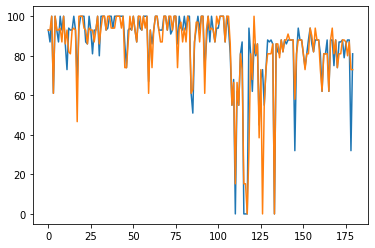

In [7]:
plt.plot(data['Lead Quality'])
plt.plot(data["Prediction (Lead Quality)"])

In [12]:
df = pd.DataFrame({'Actual': data['Lead Quality'], 'Predicted': data["Prediction (Lead Quality)"]})

In [13]:
df

Actual  Predicted
0        93       93.0
1        87       93.0
2       100      100.0
3        61       61.0
4       100      100.0
..      ...        ...
175      86       87.0
176      88       80.0
177      88       87.0
178      32       73.0
179      81       73.0

[180 rows x 2 columns]

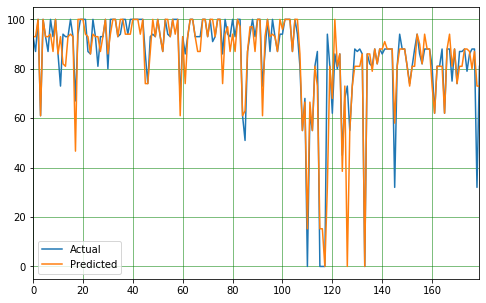

In [23]:
df.plot(kind='*',figsize=(8,5))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')